In [1]:
%load_ext autoreload
%autoreload 2
## DriftMLP is the package implementing this methodology
import DriftMLP
## h3 to convert locations to their h3 indices.
## Where possible we use DriftMLP.helpers.return_h3_inds()
h3_sys = DriftMLP.drifter_indexing.discrete_system.DefaultSystem

## core python packages
import os
import numpy as np #
import pandas as pd
import pickle
import gc


## Matplotlib for plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

## Cartopy for map projections
import cartopy.crs as ccrs
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
line_trans = 0.03


## geopandas for aid storing Polygons and plotting
import geopandas as gpd
from shapely.geometry import Polygon


import string
alphabet = string.ascii_lowercase


driftfile = os.environ['DRIFTFILE'] 
### Generated by MakeDefNetworks
networks = pickle.load(open('default_networks.p', 'rb'))

### Only use drogued drifters
network = networks[True]
DriftMLP.helpers.remove_undesired(network)
postfix = 'drg'
del networks
### Our example locations are in locations.txt
stations = np.loadtxt("locations.txt", delimiter=',')
stations = pd.DataFrame(stations, index=range(1, 8))
stations.columns = ['Longitude', 'Latitude']
stations['h3'] = h3_sys.return_inds([i[['Longitude', 'Latitude']].to_list() for _,i in stations.iterrows()])
stations.loc[:,['Longitude', 'Latitude']].to_latex()
gc.collect()
print(sum([1 if len(i)>0 else 0 for i in network['stories']]))
#DriftMLP.helpers.add_link(network)

22445


In [2]:
print(sum([1 if len(i)>0 else 0 for i in network['stories']]))

22445


# Figure 5

In [3]:
crs = ccrs.Robinson()

def cuts2poly(lon_left, lon_right, lat_bottom, lat_top):
    return Polygon(np.array([(lon_left, lat_bottom), (lon_right, lat_bottom),
                             (lon_right, lat_top), (lon_left, lat_top)]))

def return_travel_time_df(h3_ind,get_return=True):
    lon_len, lat_len=145, 73
    #lon_len, lat_len = 181, 91
    lon_ranges = np.linspace(-180, 180, lon_len)
    lat_ranges = np.linspace(-90, 90, lat_len)

    poly_limits = [(lon_ranges[i],
                    lon_ranges[i+1],
                    lat_ranges[j], lat_ranges[j+1])
                   for i in range(len(lon_ranges)-1)
                   for j in range(len(lat_ranges)-1)]

    poly_centers = [((i[1]+i[0])/2, (i[3]+i[2])/2) for i in poly_limits]

    h3_centers = h3_sys.return_inds(poly_centers)

    polygons = [cuts2poly(*poly_limit) for poly_limit in poly_limits]

    all_paths_away = DriftMLP.shortest_path.get_all_paths(network, h3_ind, h3_centers)
    
    
    tts = [path.travel_time/365 for path in all_paths_away]
  
    plot_data = gpd.GeoDataFrame({'geometry': polygons, 'traveltime': tts}, crs=None)
    ## Drop land polygons, and non accesible polygons.

#    plot_data['traveltime'] = plot_data.loc[:,'traveltime']/365
    if get_return:
        all_paths_into = [DriftMLP.shortest_path.network_path(network, h3_center, h3_ind) for h3_center in h3_centers]
        tts_return = [path.travel_time/365 for path in all_paths_into]
        plot_data['incoming_traveltime'] = tts_return
    return plot_data


point1 = -160.449222,29.529525
point2 = 30.462885, -32.634840 
h3_ind1 = h3_sys(lon=point1[0], lat=point1[1])
h3_ind2 = h3_sys(lon=point2[0], lat=point2[1])
travel_times_df1=return_travel_time_df(h3_ind1)
travel_times_df2=return_travel_time_df(h3_ind2)

/home/omalley3/Docs/DriftMLP/DriftMLP/shortest_path/__init__.py:70: RuntimeWarning: Couldn't reach some vertices at /home/conda/feedstock_root/build_artifacts/python-igraph_1588168236277/work/vendor/source/igraph/src/structural_properties.c:4726
  sps = network.get_shortest_paths(from_node, to_nodes, weights=weight)
/home/omalley3/Docs/DriftMLP/DriftMLP/shortest_path/__init__.py:40: RuntimeWarning: Couldn't reach some vertices at /home/conda/feedstock_root/build_artifacts/python-igraph_1588168236277/work/vendor/source/igraph/src/structural_properties.c:4726
  all_sp = network.get_shortest_paths(node_from, node_to, weights=weight)


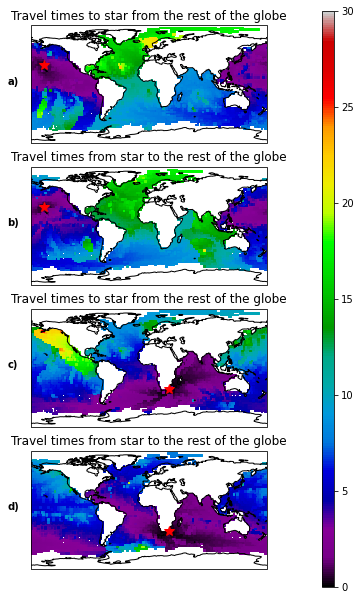

In [4]:
## Color bar settings
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(4, 1, subplot_kw={'projection': crs},
                        figsize=(5.5, 10))
norm = plt.Normalize(vmin =0, vmax=30)
#norm.autoscale(travel_times_df1['traveltime'])
cmap = plt.get_cmap('nipy_spectral')
def plot_travel_time_df(travel_time_df, norm, ax,col = 'traveltime',
                       source=[0,0]):

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)





    # Make the CartoPy plot by adding the polygons colored by the travel time
    plot_df = travel_time_df.query(f"{col}>0")
    for color, rows in plot_df.groupby(col):
        color_mapped = sm.cmap(norm(color))
        ax.add_geometries(rows['geometry'], crs=ccrs.PlateCarree(),
                           facecolor=color_mapped, edgecolor=color_mapped)
    ax.coastlines()
    #q = ax.get_extent()
    
    
    
    ax.plot(source[0], source[1], '*',
             color='red', markersize=10, transform=ccrs.Geodetic())
    ax.set_global()
    
    
plot_travel_time_df(travel_times_df1, norm, axs[1], source=point1)
axs[1].set_title("Travel times from star to the rest of the globe")
plot_travel_time_df(travel_times_df1, norm, axs[0], col='incoming_traveltime', source=point1)
axs[0].set_title("Travel times to star from the rest of the globe")
plot_travel_time_df(travel_times_df2, norm, axs[3], source=point2)
axs[3].set_title("Travel times from star to the rest of the globe")
plot_travel_time_df(travel_times_df2, norm, axs[2], col='incoming_traveltime', source=point2)
axs[2].set_title("Travel times to star from the rest of the globe")
for i in range(4):
    plot_num = alphabet[i]
    axs[i].text(-0.1,0.5,"{})".format(plot_num),transform = axs[i].transAxes, fontweight='bold')

cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])  # x0 y0 width height
cax.set_ylabel('Years', labelpad=25, rotation=270)
mpl.colorbar.ColorbarBase(cax,
                          cmap=cmap,
                          norm=norm)
fig.savefig(f"Images/tt1_{postfix}.png", bbox_inches='tight')
fig.savefig(f"Images/tt1_{postfix}.pdf", bbox_inches='tight')

From: [-147, 30], To: (30.462885, -32.63484)
Travel time for the forward journey(blue)
5437.753191500501
Travel time for the return journey(red)
2658.0598079565116

From: [-126, 42], To: (30.462885, -32.63484)
Travel time for the forward journey(blue)
7087.940875753209
Travel time for the return journey(red)
3504.4048962759002



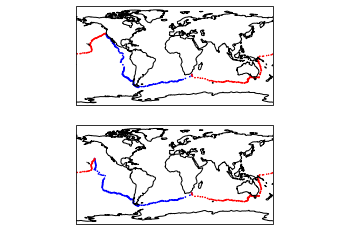

In [5]:
loc_nepac = DriftMLP.shortest_path.SingleSP(network, [-126,42], point2)
plt.figure()
ax= plt.subplot(2,1,1, projection = ccrs.PlateCarree())
loc_nepac.plot_cartopy(ax=ax)
ax= plt.subplot(2,1,2, projection = ccrs.PlateCarree())
path_nepac = DriftMLP.shortest_path.SingleSP(network, [-147,30], point2)
path_nepac.plot_cartopy(ax=ax)
print(path_nepac)
print(loc_nepac)

In [6]:
print(travel_times_df1.query("traveltime>0")['traveltime'].median())
print(travel_times_df1.query("incoming_traveltime>0")['incoming_traveltime'].median())

7.617305292257926
7.2598108483704875


In [7]:
print(travel_times_df2.query("traveltime>0")['traveltime'].median())
print(travel_times_df2.query("incoming_traveltime>0")['incoming_traveltime'].median())

4.097923365138382
5.500010518936406


# Code for making Figure 4 Below
 
 - This figure is made to show how the method succesfully follows currents

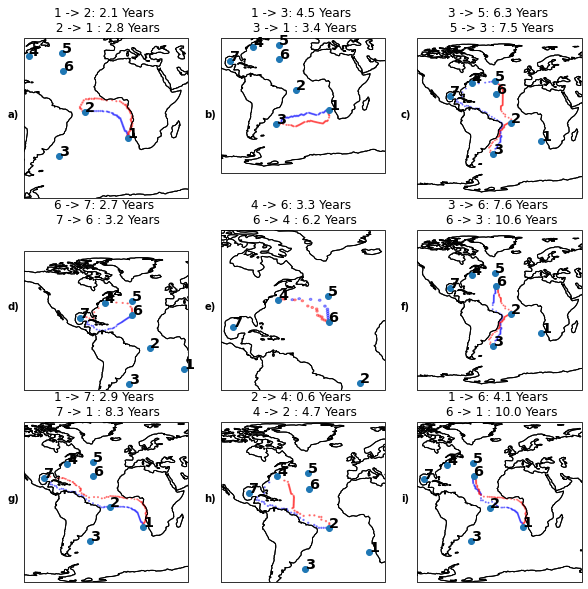

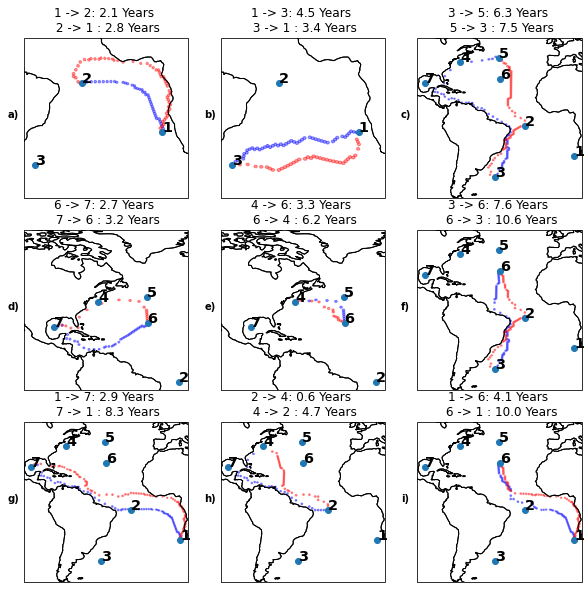

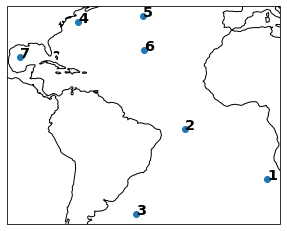

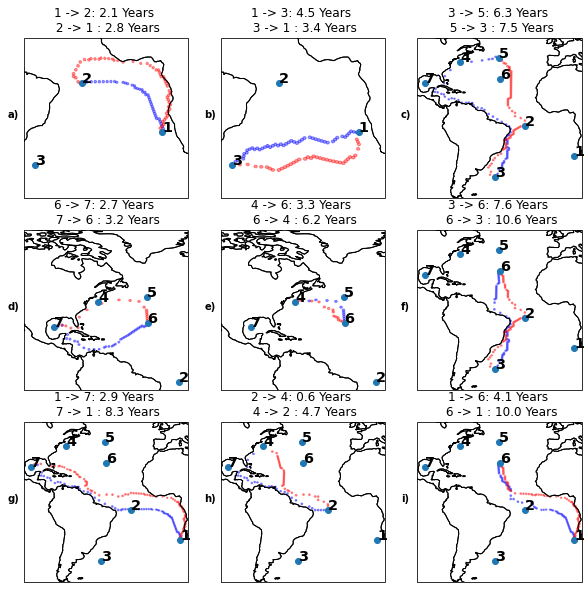

In [8]:
ods = [[0, 1], [0, 2], [2, 4], [5, 6], [3, 5], [2, 5], [0, 6], [1, 3], [0, 5]]
plt.figure()
from DriftMLP.plotting.general import plot_stations
ax = plot_stations(stations, names= stations.index)
exts = [ax.get_extent(), [-50, 20, -40, 5], [-110, -20, 1, 60]]
which_ext = [1, 1, 0, 2, 2, 0, 0, 0, 0]

def plot_there_back(od, stations, network, ax):
    loc_from, loc_to = [stations.iloc[i].loc[['Longitude', 'Latitude']].to_list()
                        for i in od]
    plot_stations(stations,names=stations.index, ax= ax)
    sp = DriftMLP.shortest_path.SingleSP(network, loc_from,loc_to)
    sp.plot_cartopy(gpd_df= network['gpd'], ax=ax, alpha=0.4)
    return sp

fig = plt.figure(figsize=(10, 10))
subplots_shape = [3, 3]
for i in range(min(len(ods), 9)):
    ax = plt.subplot(
        subplots_shape[0], subplots_shape[1],
        i+1, projection=ccrs.PlateCarree())
    #current_ext = exts[which_ext[i]]
    #oscar_arrows(cubes[zonal], cubes[mer], lon_range=current_ext[:2],
    #             lat_range=current_ext[2:4], res=[2, 2], axes=ax)
    sp = plot_there_back(ods[i], stations, network, ax=ax)
    tt1 = sp.sp.travel_time
    tt2 = sp.sp_rev.travel_time
    #ax.set_extent(exts[which_ext[i]])
    from_st, to_st = ods[i]
    ax.set_title(
        "{} -> {}: {} Years \n {} -> {} : {} Years".
        format(from_st+1, to_st+1, round(tt1/365, 1),
               to_st+1, from_st+1, round(tt2/365, 1)))
    plot_num = alphabet[i]
    ax.text(-0.1, 0.5, "{})".format(plot_num),
            transform=ax.transAxes, fontweight='bold')
display(fig)
for ax, ext_ind in zip(fig.axes, which_ext):
    ax.set_extent(exts[ext_ind])
display(fig)
fig.savefig(f'Images/pathways_{postfix}.pdf', bbox_inches='tight')

## Figure 6

21.257517516782137
10.764782209031766


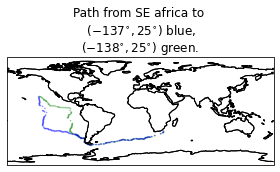

In [9]:
fig, ax = plt.subplots(1,1, subplot_kw = {'projection':ccrs.PlateCarree()},figsize =(4,2.5))
rc('text', usetex=True)
loc1 = stations.iloc[0].loc[['Longitude', 'Latitude']].to_list()

# Get the shortest paths 
path1 = DriftMLP.shortest_path.SingleSP(network, [-137,25] , point2)
path2 = DriftMLP.shortest_path.SingleSP(network, [-138,25],point2 )

# plot the pathways and the print the times
path1.plot_cartopy(ax= ax, gpd_df = network['gpd'], rev=False, color='green',alpha=0.3)
path2.plot_cartopy(ax= ax, gpd_df = network['gpd'], rev=False, alpha=0.3)
print(path1.sp.travel_time/365)
print(path2.sp.travel_time/365)

##Figure layout
#ax.set_title('Path from location 1 to \n ($-100^{\circ},-6^{\circ})$ blue, \n($-100^{\circ},-5^{\circ}$) green.')
ax.set_title("Path from SE africa to \n ($-137^{\circ},25^{\circ})$ blue, \n($-138^{\circ},25^{\circ}$) green.")
ax.axis('auto')
fig.tight_layout()
fig.savefig(f'Images/example_path_new_{postfix}.pdf')
fig.savefig(f'Images/example_path_new_{postfix}.png')
rc('text', usetex=False)

# Note: 
the following uses results from a computationally intensive script, hence why we load in data which was generated by a script.

rotations_x.p generates x random rotation matrices. This is produced from MakeRotations.py. It requires roughly 1gb ram per parallel process. The run time is approximately x*3/num_processes. Rotations_100.p took me approximately 1.5 hours to make.


In addition to this the below is quite heavy to run as we load in 100 rotation networks taking around 8gb of ram. In practical applications it would be better just to store the pathways and the rotation used for the particular application instead of making Rotations_100.p. That way the networks do not need to be saved, which makes this script light to run.

- The neccesary gpd's can be made purely from the rotation and the h3 indices in the pathways using DriftMLP.plotting.make_h3_gpd 

I stored the networks for experimental purposes. It allows me to have the flexibility to add extra locations if needed.

# Figure 9


In [10]:
### Loads in a list of 100 rotation networks 
if 'nets' not in globals():
    nets = pickle.load(open('rotations_100.p', 'rb'))
origins = [stations.iloc[i].loc[['Longitude', 'Latitude']].to_list() for i in range(stations.shape[0])]
plot_n=len(nets)
from shapely.geometry import Point
def get_all_h3id_l_paths(list_of_paths):
    return [i for paths in list_of_paths for path in paths for i in path.h3id]
def path_and_df(network, original_gpd):
    network_sys = DriftMLP.drifter_indexing.discrete_system.h3_default(rot=network['rotation'])
    indices = network_sys.return_inds(origins)
    paths = [DriftMLP.shortest_path.get_all_paths(network, src, indices) for src in  indices]
    ##We didn't store all the gpd dataframes originally as its' costly memorywise
    list_of_h3= get_all_h3id_l_paths(paths)
    rot = network['rotation']
    h3_df = DriftMLP.plotting.make_gpd.list_to_multipolygon_df(list_of_h3, discretizer=network_sys)
    return {'paths':paths, 'gpd':h3_df, 'rot':rot}

#For each path, obta
res = []
for i in range(plot_n):
    res.append(path_and_df(nets[i], network['gpd']))

In [11]:
##Get a 3d matrix of travel times, axis 0 being length 100 for the rotations. axis 1,2 being legnth 7
travel_times = np.array([
    [
            [path.travel_time for path in list_of_paths]
        for list_of_paths in res[i]['paths']]
    for i in range(len(res))])
##If this doesn't say n_rot, n_stations, n_stations fix it
print(travel_times.shape)
### Get the sample mean and std
mean_tts = travel_times.mean(axis=0)
var_tts = travel_times.var(axis=0,ddof=1)

##Which pair is most variable out of interest, turns out to be 4 to 3 in plot indcies.
np.where(var_tts==np.max(var_tts))

(100, 7, 7)


(array([3]), array([2]))

6003

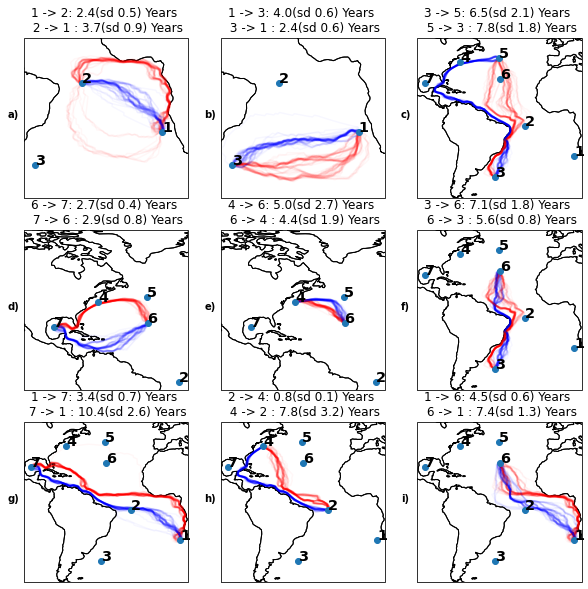

In [12]:
from shapely.geometry import Point

## adds a line to axis, essentially a wrapper function.
def plot_rotated_line(h3_gpd, h3_ids, ax, *args,**kwargs):
    h3_rot = h3_gpd.loc[h3_ids]
    DriftMLP.plotting.h3_cartopy.plot_line(h3_rot, h3_ids,'centroid_col', ax=ax, fig_init=False, *args, **kwargs)

##Large figure
fig = plt.figure(figsize = (10,10))


for i in range(min(len(ods),9)):
    ## Make a new subplot and select current stations
    ax = plt.subplot(subplots_shape[0], subplots_shape[1], i+1, projection=ccrs.PlateCarree())
    from_st = ods[i][0]
    to_st = ods[i][1]
    for res_dict in res[:plot_n]:
        ##Plot the rotated lines both there and back
        plot_rotated_line(res_dict['gpd'], 
                          res_dict['paths'][from_st][to_st].h3id,
                          ax,
                          alpha=0.03, fl=False ,color='blue')
        plot_rotated_line(res_dict['gpd'], 
                          res_dict['paths'][to_st][from_st].h3id,
                          ax,
                          alpha=0.03, fl=False ,color='red')
        
    ## add stations to the plot, and set it the right extent to match figure 5
    DriftMLP.plotting.general.plot_stations(stations, ax=ax, names=list(range(1,8)), clip_on=True)
    ax.set_extent(exts[which_ext[i]])
    
    ## format the title.
    tt1 = mean_tts[ods[i][0], ods[i][1]]
    tt2 = mean_tts[ods[i][1], ods[i][0]]
    var1 = var_tts[from_st, to_st]
    var2 = var_tts[to_st, from_st]
    ax.set_title("{} -> {}: {}(sd {}) Years \n {} -> {} : {}(sd {}) Years".format(
        ods[i][0]+1, ods[i][1]+1, round(tt1/365,1), round(np.sqrt(var1)/365, 1),
        ods[i][1]+1, ods[i][0]+1, round(tt2/365,1), round(np.sqrt(var2)/365, 1)))
    plot_num = alphabet[i]
    ax.text(-0.1,0.5,"{})".format(plot_num),transform = ax.transAxes, fontweight='bold')
    ax.set_adjustable('datalim')

    ax.coastlines()
#fig.tight_layout()
#fig.savefig('Images/rotation_results.pdf', bbox_inches='tight')
fig.savefig('Images/rotation_results.png', bbox_inches='tight')
gc.collect()

# Figure 8

77
17.657123686609822
18.873964796282163


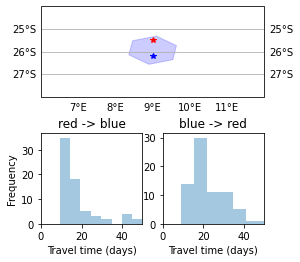

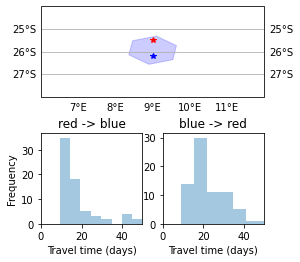

In [13]:
i=0
new_pos = [stations.iloc[i,0], stations.iloc[i,1]-0.7]
stat1 = [stations.iloc[i,0], stations.iloc[i,1]]
import matplotlib.gridspec as gridspec
def get_tt(network):
    discretizer= DriftMLP.drifter_indexing.discrete_system.h3_default(rot=network['rotation'])
    return DriftMLP.shortest_path.SingleSP(network, new_pos, stat1, discretizer =discretizer)
sps = [get_tt(net) for net in nets]
no_rot = get_tt(network)
non_zeros = [sp.sp.travel_time for sp in sps if sp.sp.travel_time!=0]
non_zeros_ret = [sp.sp_rev.travel_time for sp in sps if sp.sp_rev.travel_time !=0]
fig = plt.figure(figsize=(4,4))
gs = fig.add_gridspec(2, 2)
ax = plt.subplot(gs[0,:], projection=ccrs.PlateCarree())
no_rot.plot_cartopy(ax=ax, color='blue', alpha=0.2,rev=False)
ax.set_extent([6,12,-28,-24])

ax.plot(stations.iloc[i,0], stations.iloc[i,1],'r*', transform=ccrs.PlateCarree())
ax.plot(new_pos[0], new_pos[1],'b*', transform=ccrs.PlateCarree())
#gt_plot.add_standard_gridlines(ax, x_locs = [-180]+list(range(6,12,2))+[180], y_locs = list(range(-28,-24)))

ax_bar = plt.subplot(gs[1,0])
ax_ret = plt.subplot(gs[1,1], sharex=ax_bar)
ax_bar.set(xlabel='Travel time (days)', ylabel='Frequency', title='red -> blue')

sns.distplot(non_zeros, ax =ax_bar, kde = False)
sns.distplot(non_zeros_ret, ax =ax_ret, kde=False)

##Axis styling
ax_bar.set_xlim([0,50])
ax_ret.set(xlabel='Travel time (days)', ylabel='', title='blue -> red')
plt.subplots_adjust(hspace=0.4)
ax.axis('auto')
ax.set_extent([6,12,-28,-24])
#fig.tight_layout()
gl = ax.gridlines(draw_labels=True)
gl.top_labels= False
gl.left_labels = True
gl.xlabels_right = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator(range(-60,60,1))
gl.ylocator = mticker.FixedLocator(range(-30,0,1))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
fig.savefig('Images/samegrid.pdf',bbox_inches='tight')
fig.savefig('Images/samegrid.png',bbox_inches='tight')

## These figures are quoted in the paper
print(len(non_zeros))
print(np.mean([sp.sp.travel_time for sp in sps]))
print(np.mean([sp.sp_rev.travel_time for sp in sps]))
fig



# Figure 8

In [14]:
bootstrap_paths = pickle.load(open('bootstrapped_drg_200.p', 'rb'))
n_boot = len(bootstrap_paths)
def get_attr_from_nestedlists(nestedlists, attr_name):
    return [[getattr(path, attr_name) for path in list_of_paths] for list_of_paths in nestedlists]
bootstrap_traveltimes= np.array([get_attr_from_nestedlists(path_collection, 'travel_time') for path_collection in bootstrap_paths])
bootstrap_tt_mean = bootstrap_traveltimes.mean(axis=0)
bootstrap_tt_var= bootstrap_traveltimes.var(axis=0, ddof=1)

In [15]:
bootstrap_tt_mean
od_example = [0,2]
from_st = od_example[0]
to_st = od_example[1]
bootstrap_to = [nested_list[from_st][to_st] for nested_list in bootstrap_paths]
bootstrap_back = [nested_list[to_st][from_st] for nested_list in bootstrap_paths]

Going from 0 , to 2,full_tt: 4.528924496305349 mean: 3.6152427547984187 std: 0.6389607958094741rot_mean: 3.988042747146104
Going from 2 , to 0,full_tt: 3.36869632047085 mean: 2.2387179881282586 std: 0.496332590551887rot_mean: 2.3937348138629133


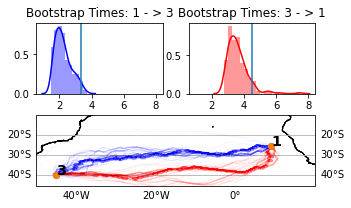

In [16]:

fig = plt.figure(figsize=(5,3))
gs = fig.add_gridspec(2, 2)
## Make the three axis 
## For: histogram there, histogram back and a map to show the pathways.
ax_bar = fig.add_subplot(gs[0,1])
ax_bar_ret = fig.add_subplot(gs[0,0], sharex = ax_bar)
ax_map = fig.add_subplot(gs[1,:], projection = ccrs.PlateCarree())

##Distirubtion of travel times
sns.distplot(bootstrap_traveltimes[:,from_st,to_st]/365, ax=ax_bar,color='red')
sns.distplot(bootstrap_traveltimes[:,to_st,from_st]/365, ax=ax_bar_ret, color='blue')

## Add a line at the original full travel time.
loc_from = stations[['Longitude', 'Latitude']].iloc[from_st].to_list()
loc_to =stations[['Longitude', 'Latitude']].iloc[to_st].to_list()
sp = DriftMLP.shortest_path.SingleSP(network, loc_from,loc_to)
ax_bar_ret.axvline(sp.sp_rev.travel_time/365)
ax_bar.axvline(sp.sp.travel_time/365)


ax_bar.set_xlabel('Years')
ax_bar_ret.set_xlabel('Years')




ax_bar.set_title('Bootstrap Times: 3 - > 1')
ax_bar_ret.set_title('Bootstrap Times: 1 - > 3')

plot_there_back(od_example,stations,network, ax= ax_map)


for i in range(n_boot):
    plot_rotated_line(network['gpd'], 
                          bootstrap_to[i].h3id,
                          ax=ax_map,
                          alpha=0.01, fl=False ,color='blue')
    plot_rotated_line(network['gpd'], 
                          bootstrap_back[i].h3id,
                          ax_map,
                          alpha=0.01, fl=False ,color='red')
ax_map.coastlines()
ax_map.axis('auto')
DriftMLP.plotting.general.plot_stations(stations, ax=ax_map)
ax_map.set_extent([-50,20,-40,-10])
plt.subplots_adjust(hspace=0.3)
gl = ax_map.gridlines(draw_labels=True)
gl.top_labels= False
gl.left_labels = True
gl.xlabels_right = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator(range(-60,60,20))
gl.ylocator = mticker.FixedLocator(range(-80,0,10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig.savefig('Images/Bootstrap_Ex.pdf', bbox_inches='tight')
fig.savefig('Images/Bootstrap_Ex.png', bbox_inches='tight')
print(f"Going from {from_st} , to {to_st},"
      f"full_tt: {sp.sp.travel_time/365}"
      f" mean: {bootstrap_tt_mean[from_st, to_st]/365}"
      f" std: {np.sqrt(bootstrap_tt_var[from_st, to_st]/(365**2))}"
     f"rot_mean: {mean_tts[from_st, to_st]/365}")
print(f"Going from {to_st} , to {from_st},"
      f"full_tt: {sp.sp_rev.travel_time/365}"
      f" mean: {bootstrap_tt_mean[to_st, from_st]/365}"
      f" std: {np.sqrt(bootstrap_tt_var[to_st, from_st]/(365**2))}"
      f"rot_mean: {mean_tts[to_st, from_st]/365}")

## Replicate of Figure 9 with bootstrap instead of Rotations

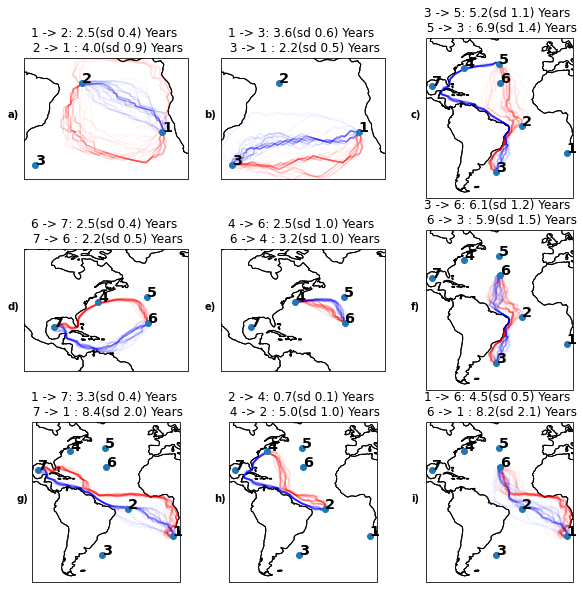

In [17]:
fig=plt.figure(figsize=(10,10))
for i in range(min(len(ods),9)):
    ## Make a new subplot and select current stations
    ax = plt.subplot(subplots_shape[0], subplots_shape[1], i+1, projection=ccrs.PlateCarree())
    from_st = ods[i][0]
    to_st = ods[i][1]
    for paths in bootstrap_paths[:60]:
        ##Plot the rotated lines both there and back
        plot_rotated_line(network['gpd'], 
                          paths[from_st][to_st].h3id,
                          ax,
                          alpha=line_trans, fl=False ,color='blue')
        plot_rotated_line(network['gpd'], 
                          paths[to_st][from_st].h3id,
                          ax,
                          alpha=line_trans, fl=False ,color='red')
        
    ## add stations to the plot, and set it the right extent to match figure 5
    DriftMLP.plotting.general.plot_stations(stations, ax=ax, names=list(range(1,8)))
    ax.set_extent(exts[which_ext[i]])
    
    ## format the title.
    tt1 = bootstrap_tt_mean[ods[i][0], ods[i][1]]
    tt2 = bootstrap_tt_mean[ods[i][1], ods[i][0]]
    var1 = bootstrap_tt_var[from_st, to_st]
    var2 = bootstrap_tt_var[to_st, from_st]
    ax.set_title("{} -> {}: {}(sd {}) Years \n {} -> {} : {}(sd {}) Years".format(
        ods[i][0]+1, ods[i][1]+1, round(tt1/365,1), round(np.sqrt(var1)/365, 1),
        ods[i][1]+1, ods[i][0]+1, round(tt2/365,1), round(np.sqrt(var2)/365, 1)))
    plot_num = alphabet[i]
    ax.text(-0.1,0.5,"{})".format(plot_num),transform = ax.transAxes, fontweight='bold')
    #ax.set_adjustable('datalim')
    fig.savefig("60_bootstrap_pairwise.pdf")
    ax.coastlines()

## How many paths go into/out of the med out of the 100

In [18]:
p_med = [16.5, 34.7]
loc1 = stations[['Longitude','Latitude']].iloc[0].to_list()
def get_tt(network):
    discretizer = DriftMLP.drifter_indexing.discrete_system.h3_default(rot=network['rotation'])
    return DriftMLP.shortest_path.SingleSP(network, p_med, loc1, discretizer=discretizer)
sp_out_of_med = [] 
for rot_network in nets:
    sp_out_of_med.append(get_tt(rot_network))
sp_out = [sp.sp.travel_time for sp in sp_out_of_med]
sp_in = [sp.sp_rev.travel_time for sp in sp_out_of_med]
print(len([tt for tt in sp_out if tt>0]))
print(len([tt for tt in sp_in if tt>0]))
##delete the 100 rotations to free up ram
del nets
gc.collect()

/home/omalley3/Docs/DriftMLP/DriftMLP/shortest_path/__init__.py:40: RuntimeWarning: Couldn't reach some vertices at /home/conda/feedstock_root/build_artifacts/python-igraph_1588168236277/work/vendor/source/igraph/src/structural_properties.c:4726
  all_sp = network.get_shortest_paths(node_from, node_to, weights=weight)


3
35


109739

## Explaining the travel time from 3 to 5.

In [19]:
SP_3_5 = DriftMLP.shortest_path.SingleSP(network, stations[['Longitude','Latitude']].iloc[2].to_list(), stations[['Longitude','Latitude']].iloc[4].to_list())

5.0175075440571435


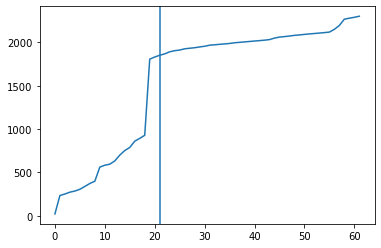

In [20]:
plt.plot(np.cumsum(SP_3_5.sp.travel_time_list))
plt.axvline(21)
print(np.sum(SP_3_5.sp.travel_time_list[0:21])/365)

In [21]:
from DriftMLP.plotting.h3_plotly import visualize_hexagons

In [22]:
m = visualize_hexagons(SP_3_5.sp.h3id[0:21], color='green')
m = visualize_hexagons(SP_3_5.sp.h3id[21:], color='blue', folium_map=m)
m

In [23]:
network['gpd'].loc[paths[from_st][to_st].h3id]

,geometry,centroid_col,rotated_centroid
593000362122674175,"POLYGON ((8.45399 -25.49286, 8.34836 -26.11589...",POINT (8.991965056919469 -25.91371344664409),POINT (8.991965056919469 -25.91371344664409)
592997544624127999,"POLYGON ((9.19071 -24.67535, 9.09210 -25.29297...",POINT (9.723479075802947 -25.09182120257734),POINT (9.723479075802949 -25.09182120257734)
592998437977325567,"POLYGON ((8.76132 -23.64277, 8.66043 -24.25618...",POINT (9.287820578604334 -24.06099180588419),POINT (9.287820578604332 -24.06099180588419)
592998163099418623,"POLYGON ((8.34038 -22.61326, 8.23733 -23.22209...",POINT (8.860696855478876 -23.03279959151195),POINT (8.860696855478876 -23.03279959151195)
593013143945347071,"POLYGON ((7.92769 -21.58766, 7.82260 -22.19153...",POINT (8.441905642587574 -22.00806626799935),POINT (8.441905642587574 -22.00806626799935)
...,...,...,...
590997051936866303,"POLYGON ((-41.36553 24.39103, -41.67663 23.831...",POINT (-40.98266421062358 23.84025857334371),POINT (-40.98266421062358 23.84025857334371)
590997326814773247,"POLYGON ((-41.43768 25.50613, -41.75209 24.941...",POINT (-41.04972347999958 24.95317312765228),POINT (-41.04972347999958 24.95317312765228)
590996433461575679,"POLYGON ((-41.51166 26.62821, -41.82944 26.058...",POINT (-41.11846708247924 26.07349927503828),POINT (-41.11846708247923 26.07349927503828)
590996364742098943,"POLYGON ((-42.62439 27.15982, -42.93418 26.587...",POINT (-42.22499983660529 26.60963610588693),POINT (-42.22499983660529 26.60963610588693)
